In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import daft
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from tqdm import tqdm

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from game_simulation import CoinGameSimulation
from game_browser import CoinGameBrowser
from simulate_strategy import simulate_strategy

In [3]:
def get_pgm():
    y = 1 
    pgm = daft.PGM()
    pgm.add_node("p", r"$p$", 0, y, fixed=True, offset=(1, 3))
    pgm.add_node("L", r"$L$", 1, y)
    pgm.add_node("theta", r"$\theta$", 2, y)
    pgm.add_node("H_n", r"$H_n$", 3, y, observed=True)
    pgm.add_edge("p", "L")
    pgm.add_edge("L", "theta")
    pgm.add_edge("theta", "H_n")
    pgm.add_plate([2.5, 0.5, 1, 1], label=r"$n = 1:N$", shift=-0.2)
    return pgm.render()

### Strategy 3: make use of Bayesian inference.
This strategy uses Bayesian inference to determine the best strategy to play.

The following wikipedia pages were used as reference 
[Checking whether a coin is fair](https://en.wikipedia.org/wiki/Checking_whether_a_coin_is_fair) and [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).

The following code shows the probabilitic graphical model for the coin flip distribution.

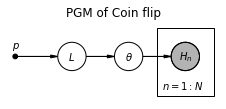

In [4]:
get_pgm().set_title("PGM of Coin flip");


- $p$: The probability of the opponent being fair.
- $L$:  Bernouilli distribution with unkown parameter p. Determines if the opponent is a cheater or not.
- $\theta$: Unkown distribution with values $\in [0, 1]$. Gives parameters of the Bernoulli distribution of H.
- $H_{1:N}$: Bernouilli distribution with parameter $\theta$ and $N$ samples. Gives the number of heads.

We use Bayes rule to get:
$$
\begin{align*}
P(L | H_{1:N}) &= \frac{P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} \\
               &= \frac{\sum_{\theta=0}^1 P(H_{1:N}, \theta | L) \cdot P(L)}{P(H_{1:N})} \\
               &= \frac{\sum_{\theta=0}^1 P(H_{1:N} | \theta, L) \cdot P(\theta | L) \cdot P(L)}{P(H_{1:N})} \\
               &= \frac{\sum_{\theta=0}^1 P(H_{1:N} | \theta) \cdot P(\theta | L) \cdot P(L)}{P(H_{1:N})} \\
               &\propto \sum_{\theta=0}^1 P(H_{1:N} | \theta) \cdot P(\theta | L) \cdot P(L) \\
\end{align*}
$$

After choosing the label, we get to know the true Label L.
We can then update the priors $P(\theta | L)$ and $P(L)$

$$
\begin{align*}
P(L | H_{1:N}) &= \frac{P(H_{1:N} | L) \cdot P(H_{})}{P(H_{1:N} | L)} \\
&= \frac{P(H_{1:N} | \theta) \cdot P(\theta | L)}{P(H_{1:N} | L)} \\
&\propto P(H_{1:N} | \theta) \cdot P(\theta | L)
\end{align*}
$$

$$
\begin{align*}
P(\theta | L, H_{1:N}) &= \frac{P(H_{1:N} | \theta, L) \cdot P(\theta | L)}{P(H_{1:N} | L)} \\
&= \frac{P(H_{1:N} | \theta) \cdot P(\theta | L)}{P(H_{1:N} | L)} \\
&\propto P(H_{1:N} | \theta) \cdot P(\theta | L)
\end{align*}
$$

In [109]:
class StrategyBayseianInference:

    def __init__(self, 
                 n = 100, 
                 threshold = 0.75, 
                 flip_5_at_start = False):
        # n is the number of theta values.
        # the threshold is the theshold to use when deciding the label.
        self.threshold = threshold 
        self.theta = np.linspace(0, 1, n)
        self.theta_L = np.zeros((n, 2))
        self.theta_L[self.theta > 0.5, 1] = 1
        self.theta_L[(0.45 < self.theta)&(self.theta < 0.55), 0] = 1
        self.theta_L /= self.theta_L.sum(axis=0)
        
        # probability of label 0: fair
        self.observed_L = [0, 1]
        self.p = np.mean(self.observed_L)

        self.last_flips_left = 0
        self.last_n_heads = 0
        self.last_n_tails = 0
        self.last_action = 0
        self.last_label = None
        self.flip_5_at_start = flip_5_at_start

    def set_theshold(self, threshold):
        assert 0 <= threshold <= 1
        self.threshold = threshold

    def update(self, reward=None, flips_left=None):  
        if self.last_label is None:
            return
        if reward is not None:
            self.get_correct_label(reward)
        elif flips_left is not None:
            flips_left_diff = flips_left - self.last_flips_left
            self.get_correct_label(flips_left_diff)
        else:
            raise ValueError("Either reward or flips_left must be given.")
        
        self.last_label = None
        c_label = self.last_correct_label

        # estimate p once again
        self.observed_L.append(c_label)
        self.p = np.mean(self.observed_L)

        # update theta_L using bayesian inference
        self.theta_L[:, c_label] = self.probability_of_observation * self.theta_L[:, c_label]
        self.theta_L /= self.theta_L.sum(axis=0)
    
    def get_correct_label(self, reward):
        if reward == 15:
            correct_label = True
        elif reward == -30:
            correct_label = False
        else:
            raise ValueError(f"Reward ({reward} is not 15 or -30.")
        
        if correct_label:
            self.last_correct_label = self.last_label
        else:
            self.last_correct_label = (self.last_label + 1) % 2


    def strategy(self, n_heads, n_tails, flips_left):
        self.last_flips_left = flips_left

        if self.flip_5_at_start and n_heads + n_tails == 0 and flips_left > 50:
            return 1
        
        theta = self.theta
        self.probability_of_observation = theta ** n_heads * (1 - theta) ** n_tails

        posterior = self.probability_of_observation.dot(self.theta_L) * np.array([self.p, 1 - self.p])
        posterior /= np.sum(posterior)

        

        if np.max(posterior) > self.threshold or flips_left == 0:
            label = np.argmax(posterior)
            self.last_label = label
            return label + 2
        else:
            return 0

In [115]:
strat = StrategyBayseianInference(n=101)
g = CoinGameSimulation()
scores = []

C:\Users\alber\AppData\Local\Temp\ipykernel_18624\4120099208.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


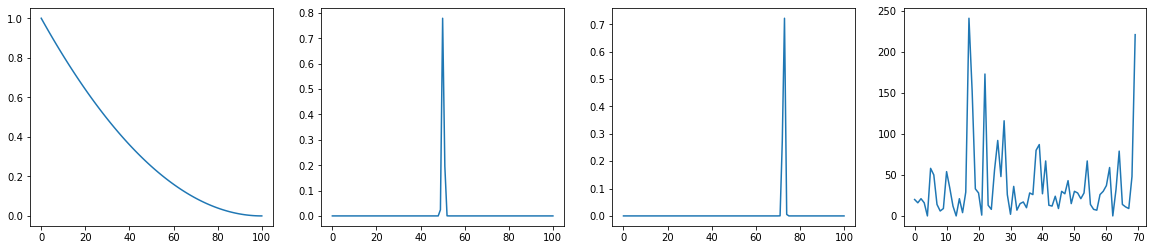

In [120]:
for i in range(100):
    (n_heads, n_tails, flips_left) = g.reset()
    done = False
    while not done:
        action = strat.strategy(n_heads, n_tails, flips_left)
        (n_heads, n_tails, flips_left), reward, done, info = g.step(action)
        strat.update(reward=reward)

    score = info["score"]
    scores.append(score)
    if score >= 100:
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 4, figsize=(20, 4))
        ax[0].plot(strat.probability_of_observation)
        ax[0]
        ax[1].plot(strat.theta_L[:, 0], label="L=0")
        ax[2].plot(strat.theta_L[:, 1], label="L=1")
        ax[3].plot(scores, label="scores")
        fig.show()
        break

In [121]:
strat.set_theshold(0.75)
simulate_strategy(strat.strategy, n_simulations=500)

score 39.846 ± 52.03166616590324
n_labels 53.024 ± 65.29324179423166
n_flips_per_game 317.344 ± 383.700823121348
n_flips_per_label 5.984912492456246 ± 4.84546168919737
reward -0.3104857871090375 ± 7.5491574183845085


In [136]:
driver = g.driver
g = CoinGameBrowser(driver=driver)

In [129]:
with open('log_bayes.txt', 'w') as f:
    f.write('Score,Flips left,Heads,Tails,Action,Reward\n')

In [137]:
for i in range(100):
    (n_heads, n_tails, flips_left) = g.reset()
    done = False
    while not done:
        action = strat.strategy(n_heads, n_tails, flips_left)
        (n_heads, n_tails, flips_left), reward, done, info = g.step(action)
        score = info["score"]
        with open('log_bayes.txt', 'a') as f:
            f.write(f'{score:3},{flips_left:3},{n_heads:2},{n_tails:2},{action:2},{reward:3}\n')

KeyboardInterrupt: 

In [159]:
import pandas as pd
df = pd.read_csv('log_bayes.txt', header=0)
print(df.dtypes)
df.head()

Score         int64
Flips left    int64
Heads         int64
Tails         int64
Action        int64
Reward        int64
dtype: object


,Score,Flips left,Heads,Tails,Action,Reward
0,0,100,0,0,0,0
1,0,99,1,0,0,-1
2,0,98,2,0,0,-1
3,0,97,2,1,0,-1
4,0,96,3,1,0,-1


In [165]:
df[df["Reward"] == 15]['Action'].value_counts()

2    232
3    226
0      1
Name: Action, dtype: int64